# Influence Of Dykes On River Network System Graph Metrics - An Analysis With FastScape

Author: Malte Springer

In [1]:
import os
import glob
from pathlib import Path
import pickle
from collections import defaultdict
from tqdm import tqdm, trange
from pympler import asizeof
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from joblib import Parallel, delayed
import xarray as xr
import xsimlab as xs
import fastscape
from fastscape.models import basic_model
from fastscape.models import sediment_model
from orographic_precipitation.fastscape_ext import precip_model
import orographic_precipitation
import topotoolbox as ttb
import pyflwdir as pfd
import pyvista as py
import networkx as netx
from networkx.algorithms.tree.branchings import maximum_branching
import rasterio as rio
from rasterio.transform import from_origin
from rasterio.crs import CRS
from shapely.geometry import LineString, Point
from shapely.strtree import STRtree
import tempfile
import traceback
import matplotlib

c:\Users\MS\miniforge3\envs\fastscape_ESPM_2025\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# Import the helper functions that run the simulation and analysis process

from Fastscape_River_Graphs import *

### 1. Set up the model with parameters

In [3]:
%load_ext xsimlab.ipython

from fastscape.processes import FlowAccumulator
model_sed = sediment_model.update_processes({'drainage': FlowAccumulator})

In [4]:
# Model Parameters - will be used in each of the different simulation runs

nx,ny = 201, 101
xl,yl = 40e3, 20e3
x,y = np.meshgrid(np.linspace(0,xl,nx), np.linspace(0,yl,ny))
tf = 10e7
tstep = xr.DataArray(np.linspace(0,tf,401), dims='tstep')
time = xr.DataArray(np.linspace(0,tf,21), dims='time')


precip_base_arr = np.ones([ny, nx])
precip_base_arr=precip_base_arr*5
xr_2d = xr.DataArray(np.ones((ny,nx)), dims=['y','x'])
precip_base_xr=xr_2d*5

In [5]:
# %create_setup model_sed
ds_in_sed = xs.create_setup(
    model=model_sed,
    clocks={'tstep':tstep, 'time':time},
    master_clock='tstep',
    input_vars={
        'grid__shape': [ny, nx], 
        'grid__length': [yl, xl],  
        'boundary__status': ['fixed_value', 'fixed_value', 'looped', 'looped'],

        'uplift__rate': 1e-4,  # m/year = 0.1 mm/yr, typical for tectonic uplift

        'init_topography__seed': None,

        'flow__slope_exp': 1.0,  

        'drainage__runoff': precip_base_xr,  

        'spl__area_exp': 0.5,  
        'spl__slope_exp': 1.0,  
        'spl__tol_rel': 1e-4,  
        'spl__tol_abs': 1e-6,  
        'spl__max_iter': 500,  

        'spl__k_coef_bedrock': 5e-6,  # typical: 1e-7 to 1e-5 (m^0.1 / yr)
        'spl__k_coef_soil': 1e-4,     # soil is usually more erodible

        'spl__g_coef_bedrock': 0.0,   # no sediment transport in pure bedrock channels
        'spl__g_coef_soil': 0.3,      # nonzero for diffusive sediment transport

        'diffusion__diffusivity_bedrock': 0.0,  # bedrock creep is negligible
        'diffusion__diffusivity_soil': 0.01,    # m²/yr, typical 1e-3 to 1e-1
    },
    output_vars={
        'topography__elevation': 'time',
        'drainage__flowacc': 'time',
        'flow__basin': 'time',
    }
)

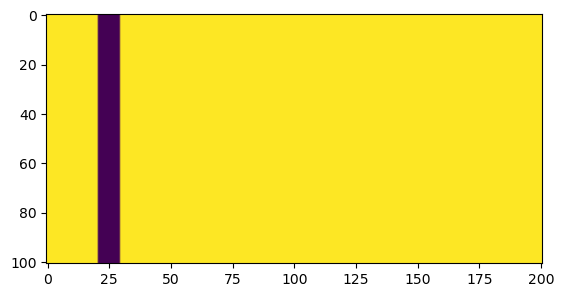

In [6]:
# Illustration of how the change in kf looks like

kf_new = xr.where((x-9.7e3)*(x-10.3e3)<0, 0.2e-5, 1e-5)

kf_new = (
                        xr.where(
                            (x < (x.max() / 2 - x.max() * 0.35)) & (x > (x.max() / 2 - x.max() * 0.4)),
                             0.2e-5, 1e-5
                        )
                    )

plt.imshow(kf_new)

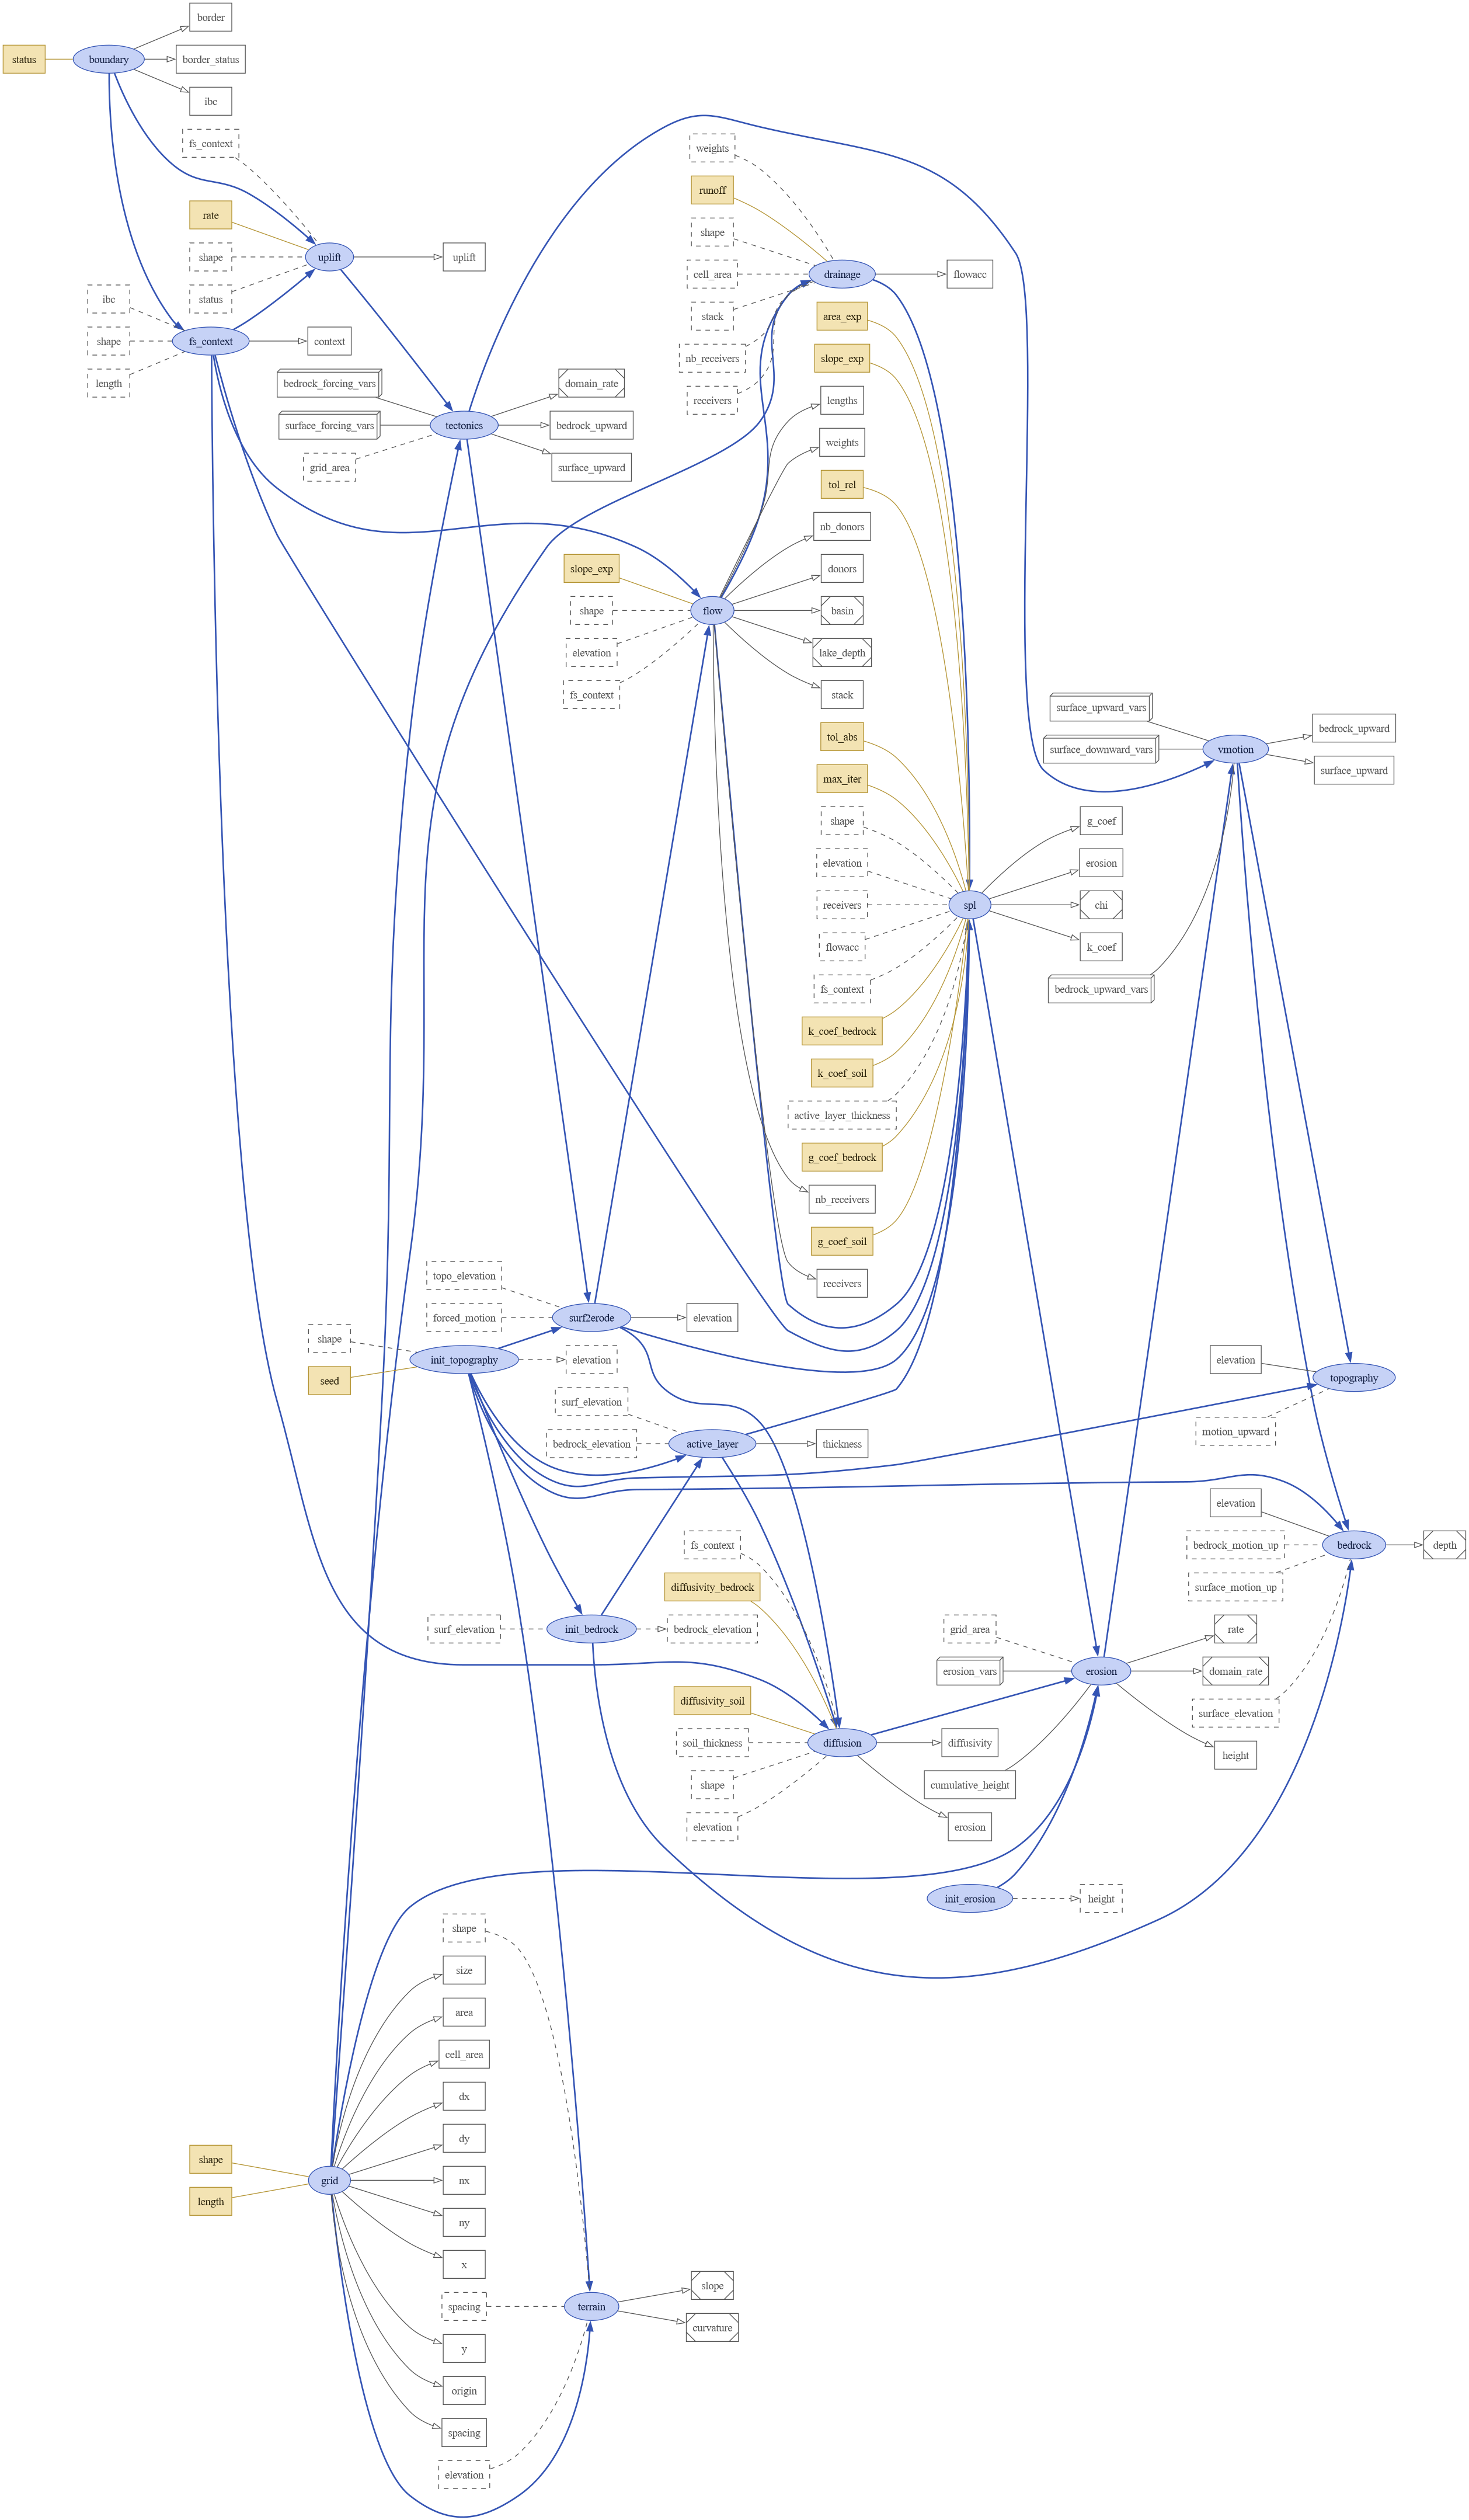

In [7]:
model_sed.visualize(show_inputs=True, show_variables=True)

In [8]:
x,y = np.meshgrid(np.linspace(0, ds_in_sed.grid__length[1], ds_in_sed.grid__shape[1].values),
                  np.linspace(0, ds_in_sed.grid__length[0], ds_in_sed.grid__shape[0].values))

x = xr.DataArray(x, dims=('y', 'x'))
y = xr.DataArray(y, dims=('y', 'x'))

### 2. Run the random fields experiment with the previously generated sediment model

In [ ]:
# Execute the experiment

EXP1 = RandomFieldExperiment(x=x, y=y) # Initialize the object instance

EXP1.generate_fields(centres=[10000, 20000, 30000], thicknesses=[100, 1000, 5000],  kfs=np.logspace(-6, -4, 10), background_kf=1e-5) # generate a bunch of random fields for the parameters mentioned in the paper

EXP1.run_experiment(model=model_sed, ds_in=ds_in_sed, n_noises=100, n_jobs=-4, storage=r"F:\ESPM") # run and store the simulation result for 100 noises per parameter combination with highly parallelized version

100%|██████████| 90/90 [3:08:20<00:00, 125.56s/it]  


### 3. Analyze the results of the simulation

In [9]:
# Re-open the relevant data for the metric analysis

p = r"F:\ESPM"

with open(Path(p) / "EXP1_field_dict.pkl", "rb") as f:
    EXP1_field_dict = pickle.load(f)

Found file_80_noise_0.nc


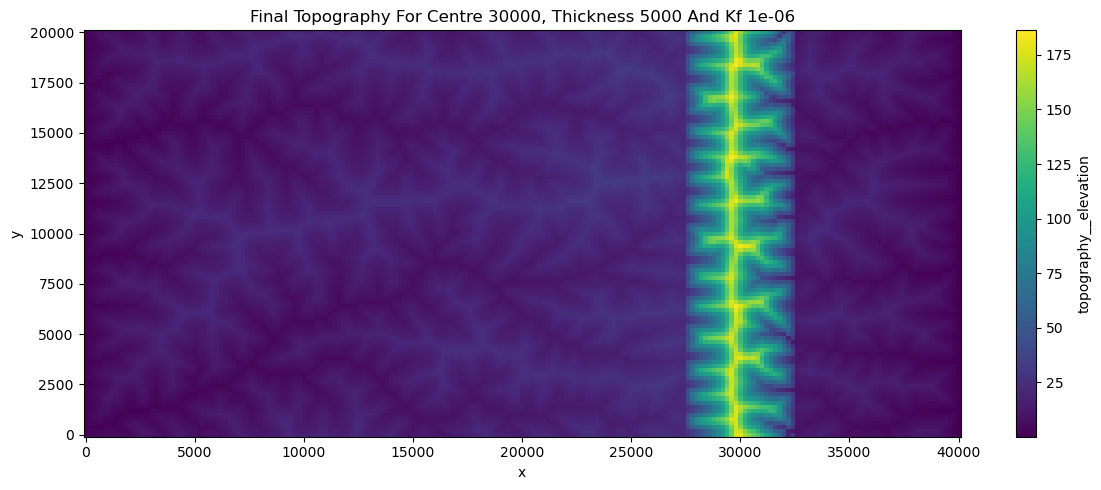

In [10]:
# Plot and check the final topography for one selected noise and parameter combination

_ = plot_sim_result(EXP1_field_dict, path=p, centre=30000, thickness=5000, kf_n=0, noise=0, visualize=True)

#### Generate the plots stored in the github plots folder

In [17]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='num_nodes', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


In [116]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='longest_path', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.
[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 14.4min remaining:  4.9min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 17.1min remaining:  2.9min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 18.8min remaining:   38.9s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 19.2min finished


In [117]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='diameter', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 18.5min remaining:  6.4min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 21.7min remaining:  3.7min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 23.9min remaining:   49.3s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 24.4min finished


In [118]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='radius', node_based=False, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 18.4min remaining:  6.3min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 21.5min remaining:  3.6min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 23.7min remaining:   48.9s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 24.2min finished


In [119]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='degree', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 14.7min remaining:  5.0min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 17.5min remaining:  2.9min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 19.1min remaining:   39.4s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 19.5min finished


In [120]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='betweenness_centrality', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 17.8min remaining:  6.1min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 20.8min remaining:  3.5min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 22.8min remaining:   47.1s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 23.3min finished


In [121]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='katz_centrality', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 14.8min remaining:  5.1min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 17.7min remaining:  3.0min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 19.4min remaining:   40.0s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 19.8min finished


In [122]:
res = simulation_analysis_joblib_callable(
    nx, ny, r"F:\ESPM", setup_dict=EXP1_field_dict,
    metric='eccentricity', node_based=True, log=True, save_as=r"F:\ESPM",
    limit=None, n_jobs=-4, backend="loky", SIM_Bundler_cls=SIM_Bundler, metric_analysis_fn=metric_analysis, verbose=10
)
print(res)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 17 concurrent workers.


Launching joblib.Parallel with backend=loky, n_jobs=-4


[Parallel(n_jobs=-4)]: Done   7 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-4)]: Done  16 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-4)]: Done  27 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-4)]: Done  51 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-4)]: Done  67 out of  90 | elapsed: 18.5min remaining:  6.4min
[Parallel(n_jobs=-4)]: Done  77 out of  90 | elapsed: 21.6min remaining:  3.7min
[Parallel(n_jobs=-4)]: Done  87 out of  90 | elapsed: 23.9min remaining:   49.3s


Completed: 90 OK, 0 ERROR
[{'i': 0, 'status': 'ok'}, {'i': 1, 'status': 'ok'}, {'i': 2, 'status': 'ok'}, {'i': 3, 'status': 'ok'}, {'i': 4, 'status': 'ok'}, {'i': 5, 'status': 'ok'}, {'i': 6, 'status': 'ok'}, {'i': 7, 'status': 'ok'}, {'i': 8, 'status': 'ok'}, {'i': 9, 'status': 'ok'}, {'i': 10, 'status': 'ok'}, {'i': 11, 'status': 'ok'}, {'i': 12, 'status': 'ok'}, {'i': 13, 'status': 'ok'}, {'i': 14, 'status': 'ok'}, {'i': 15, 'status': 'ok'}, {'i': 16, 'status': 'ok'}, {'i': 17, 'status': 'ok'}, {'i': 18, 'status': 'ok'}, {'i': 19, 'status': 'ok'}, {'i': 20, 'status': 'ok'}, {'i': 21, 'status': 'ok'}, {'i': 22, 'status': 'ok'}, {'i': 23, 'status': 'ok'}, {'i': 24, 'status': 'ok'}, {'i': 25, 'status': 'ok'}, {'i': 26, 'status': 'ok'}, {'i': 27, 'status': 'ok'}, {'i': 28, 'status': 'ok'}, {'i': 29, 'status': 'ok'}, {'i': 30, 'status': 'ok'}, {'i': 31, 'status': 'ok'}, {'i': 32, 'status': 'ok'}, {'i': 33, 'status': 'ok'}, {'i': 34, 'status': 'ok'}, {'i': 35, 'status': 'ok'}, {'i': 36, '

[Parallel(n_jobs=-4)]: Done  90 out of  90 | elapsed: 24.4min finished


### 4. Illustration of the results

In [11]:
# Model Parameters - will be used in each of the different simulation runs

nx,ny = 201, 101
xl,yl = 40e3, 20e3
x,y = np.meshgrid(np.linspace(0,xl,nx), np.linspace(0,yl,ny))
tf = 10e7
tstep = xr.DataArray(np.linspace(0,tf,401), dims='tstep')
time = xr.DataArray(np.linspace(0,tf,201), dims='time')


precip_base_arr = np.ones([ny, nx])
precip_base_arr=precip_base_arr*5
xr_2d = xr.DataArray(np.ones((ny,nx)), dims=['y','x'])
precip_base_xr=xr_2d*5

In [12]:
# %create_setup model_sed
ds_in_sed = xs.create_setup(
    model=model_sed,
    clocks={'tstep':tstep, 'time':time},
    master_clock='tstep',
    input_vars={
        'grid__shape': [ny, nx], 
        'grid__length': [yl, xl],  
        'boundary__status': ['fixed_value', 'fixed_value', 'looped', 'looped'],

        'uplift__rate': 1e-4,  # m/year = 0.1 mm/yr, typical for tectonic uplift

        'init_topography__seed': None,

        'flow__slope_exp': 1.0,  

        'drainage__runoff': precip_base_xr,  

        'spl__area_exp': 0.5,  
        'spl__slope_exp': 1.0,  
        'spl__tol_rel': 1e-4,  
        'spl__tol_abs': 1e-6,  
        'spl__max_iter': 500,  

        'spl__k_coef_bedrock': 5e-6,  # typical: 1e-7 to 1e-5 (m^0.1 / yr)
        'spl__k_coef_soil': 1e-4,     # soil is usually more erodible

        'spl__g_coef_bedrock': 0.0,   # no sediment transport in pure bedrock channels
        'spl__g_coef_soil': 0.3,      # nonzero for diffusive sediment transport

        'diffusion__diffusivity_bedrock': 0.0,  # bedrock creep is negligible
        'diffusion__diffusivity_soil': 0.01,    # m²/yr, typical 1e-3 to 1e-1
    },
    output_vars={
        'topography__elevation': 'time',
        'drainage__flowacc': 'time',
        'flow__basin': 'time',
    }
)

#### a) Dynamical development

In [13]:
noises = [np.random.random(x.shape) for i in range(0,10)] # just 10 different initial noises here

def run_model_parallel(model, ds_in, x, y, noise):
    with model.drop_processes('init_topography'):
        ds_out =  ds_in.xsimlab.update_vars(
            input_vars={
                'topography__elevation': 
                    noise,
                'spl__k_coef_bedrock' : kf_new
            }
        ).xsimlab.run()

    return ds_out

results_test = Parallel(n_jobs=-4)(delayed(run_model_parallel)(model_sed, ds_in_sed, x, y, noise=n) for n in noises)

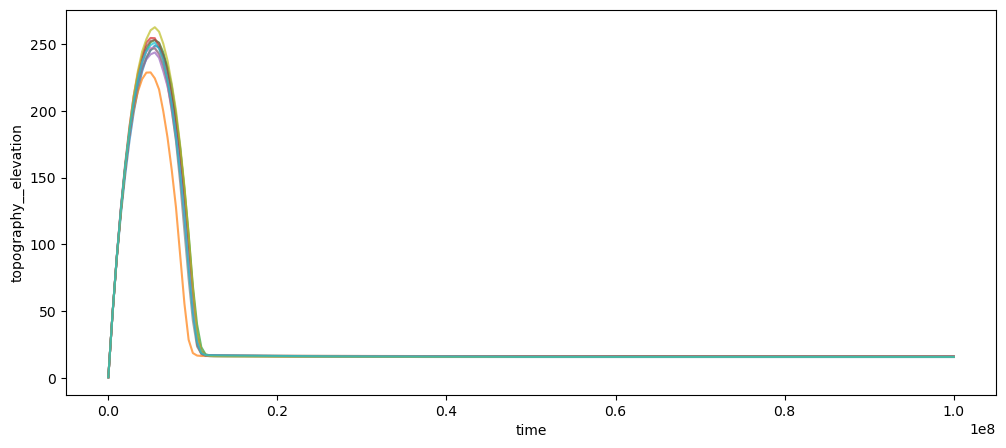

In [14]:
plt.figure(figsize=(12,5))
[run.topography__elevation.mean(("x", "y")).plot(alpha=0.7) for run in results_test]
plt.show()

#### b) Topography

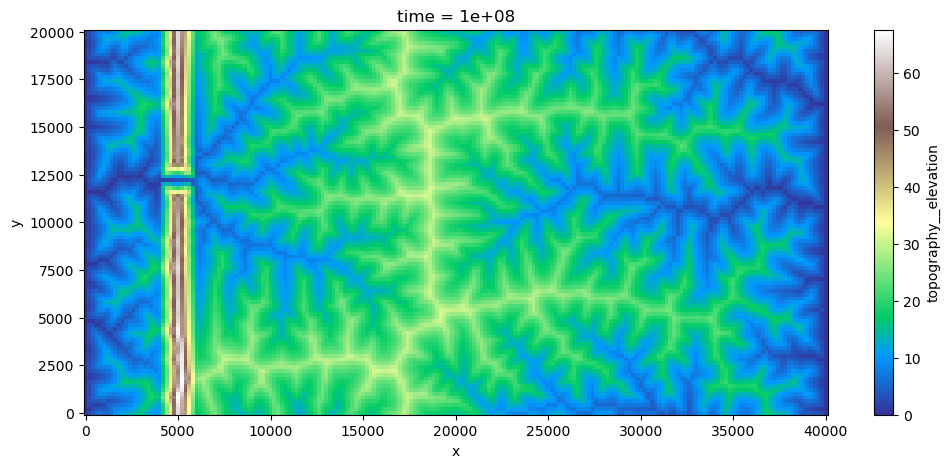

In [15]:
results_test[0].topography__elevation.isel(time=-1).plot(figsize=(12, 5), cmap="terrain", vmin=0)

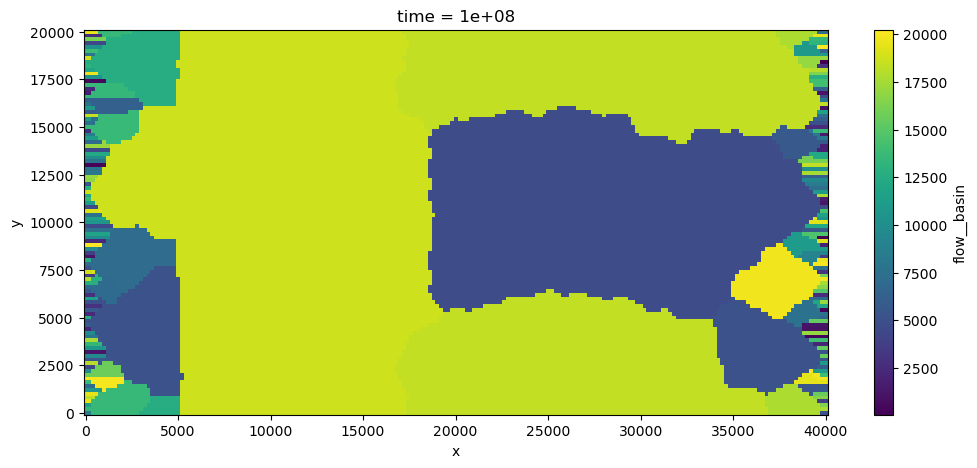

In [16]:
results_test[0].flow__basin.isel(time=-1).plot(figsize=(12, 5))

#### c) Corresponding graphs

In [17]:
SIM_Test = SIM_Bundler(results_list=results_test, ny=ny, nx=nx)
SIM_Test.fastscape2graphs(parallel=True)

c:\Users\MS\miniforge3\envs\fastscape_ESPM_2025\lib\site-packages\networkx\linalg\laplacianmatrix.py:432: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  evals, evecs = sp.sparse.linalg.eigs(P.T, k=1)


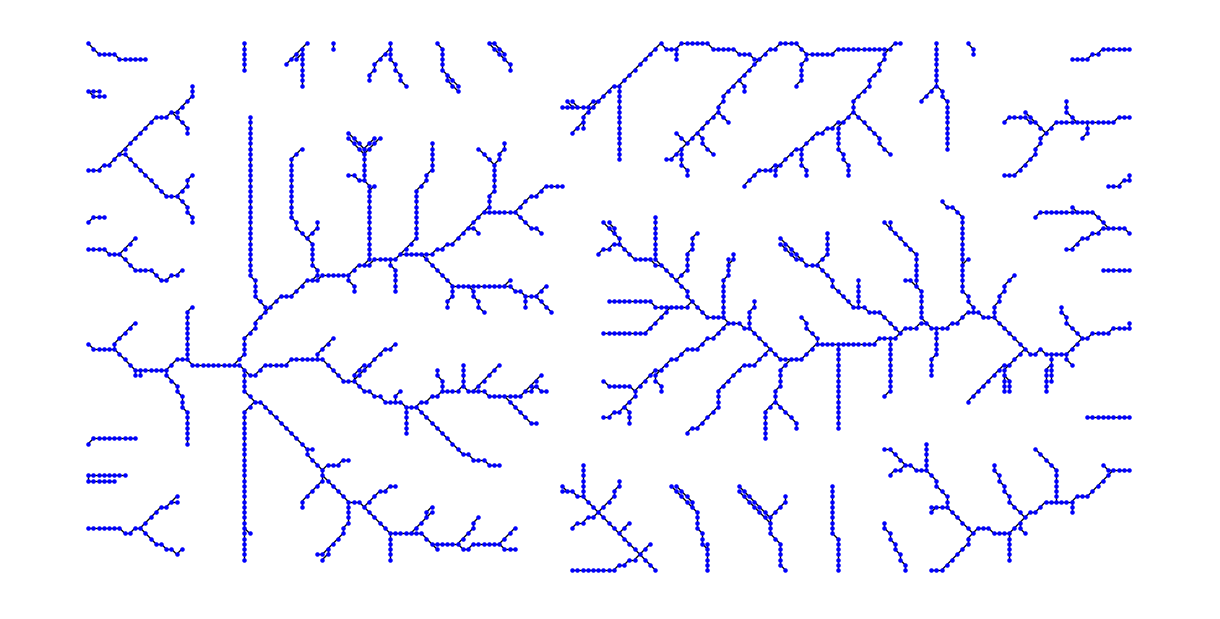

In [18]:
plt.figure(figsize=(12, 6))

for _, G in SIM_Test.runs[0]["graphs"].items():
    pos = {n: n for n in G.nodes}
    netx.draw(G, pos=pos, node_size=5, node_color="blue", arrows=False)

plt.show()

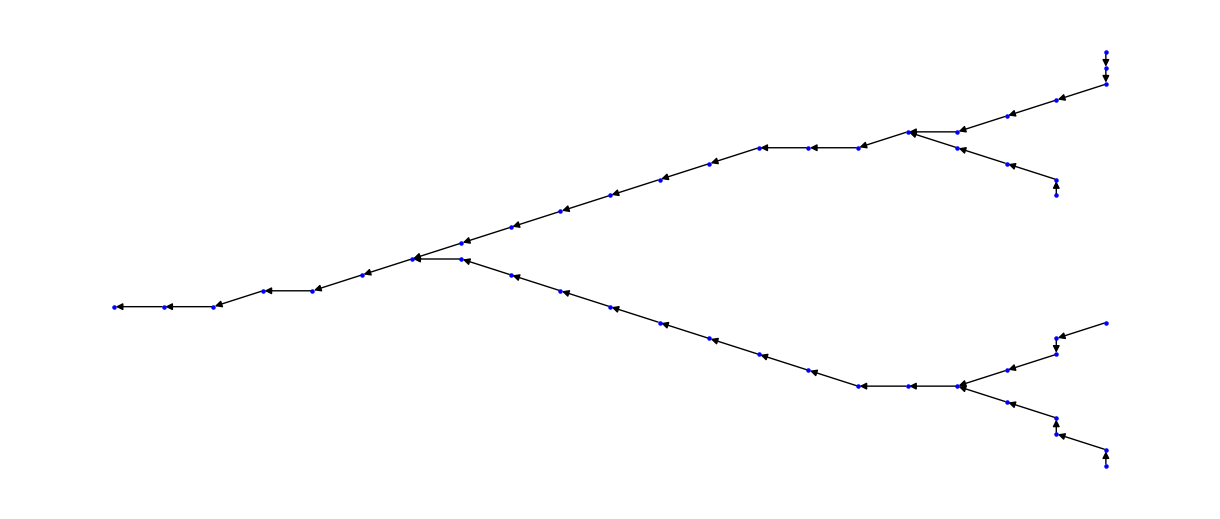

In [26]:
G = SIM_Test.runs[0]["graphs"][3]

plt.figure(figsize=(12, 5))
pos = {n: n for n in G.nodes}
netx.draw(G, pos=pos, node_size=5, node_color="blue", arrows=True)
plt.show()

#### d) Graph Metrics

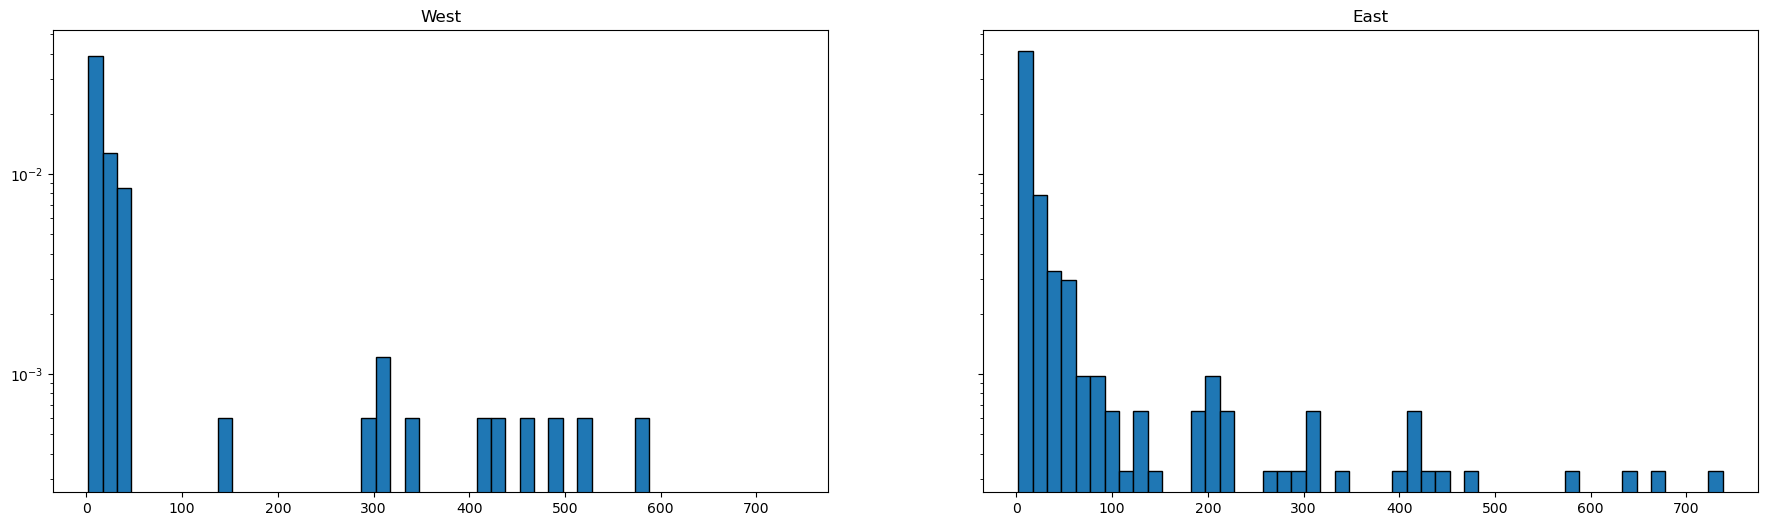

In [27]:
_ = metric_analysis(SIM=SIM_Test, metric='num_nodes', node_based=False, visualize=True, log=True, bin_num=50)

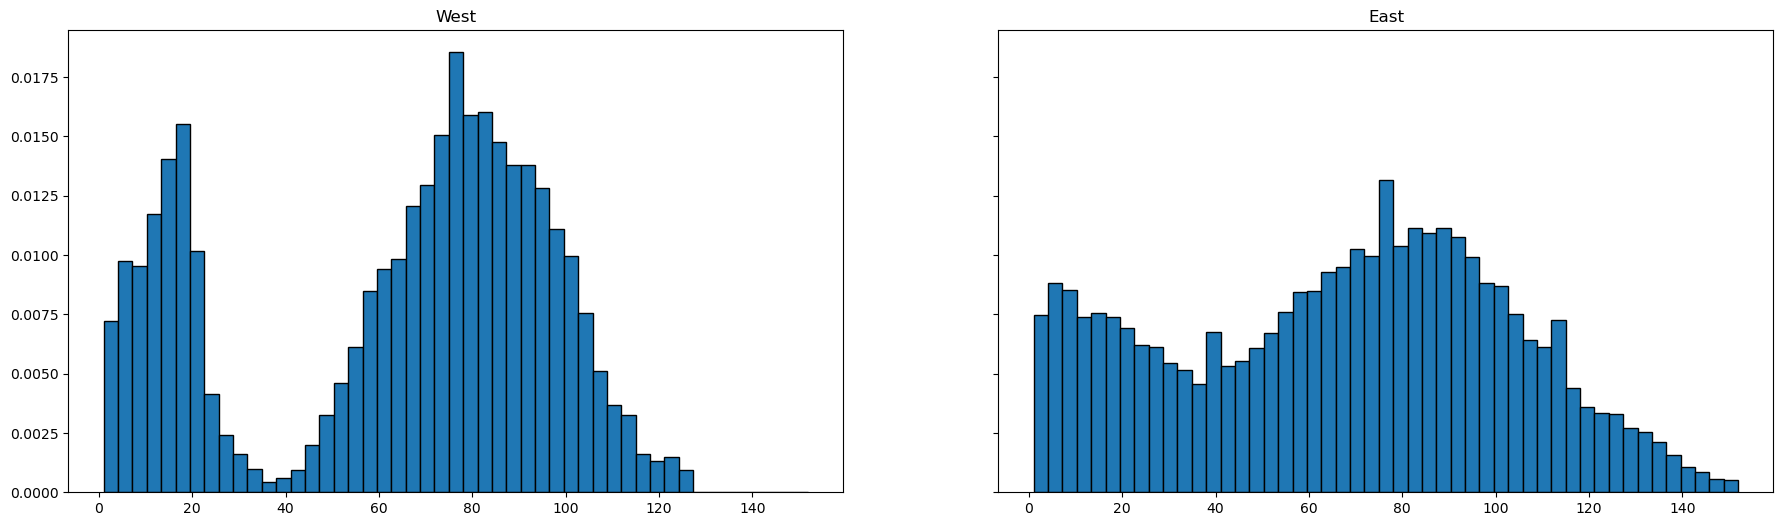

In [21]:
_ = metric_analysis(SIM=SIM_Test, metric='eccentricity', node_based=True, visualize=True, log=False, bin_num=50)

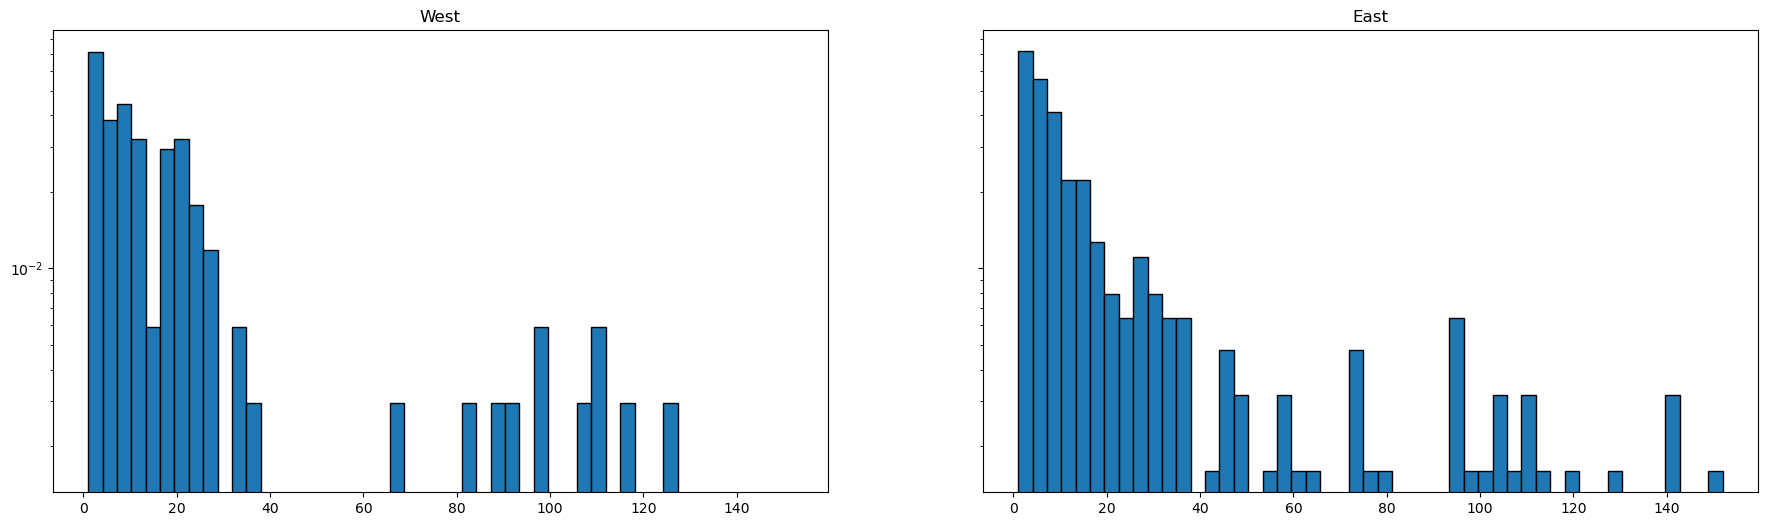

In [28]:
_ = metric_analysis(SIM=SIM_Test, metric='diameter', node_based=False, visualize=True, log=True, bin_num=50)

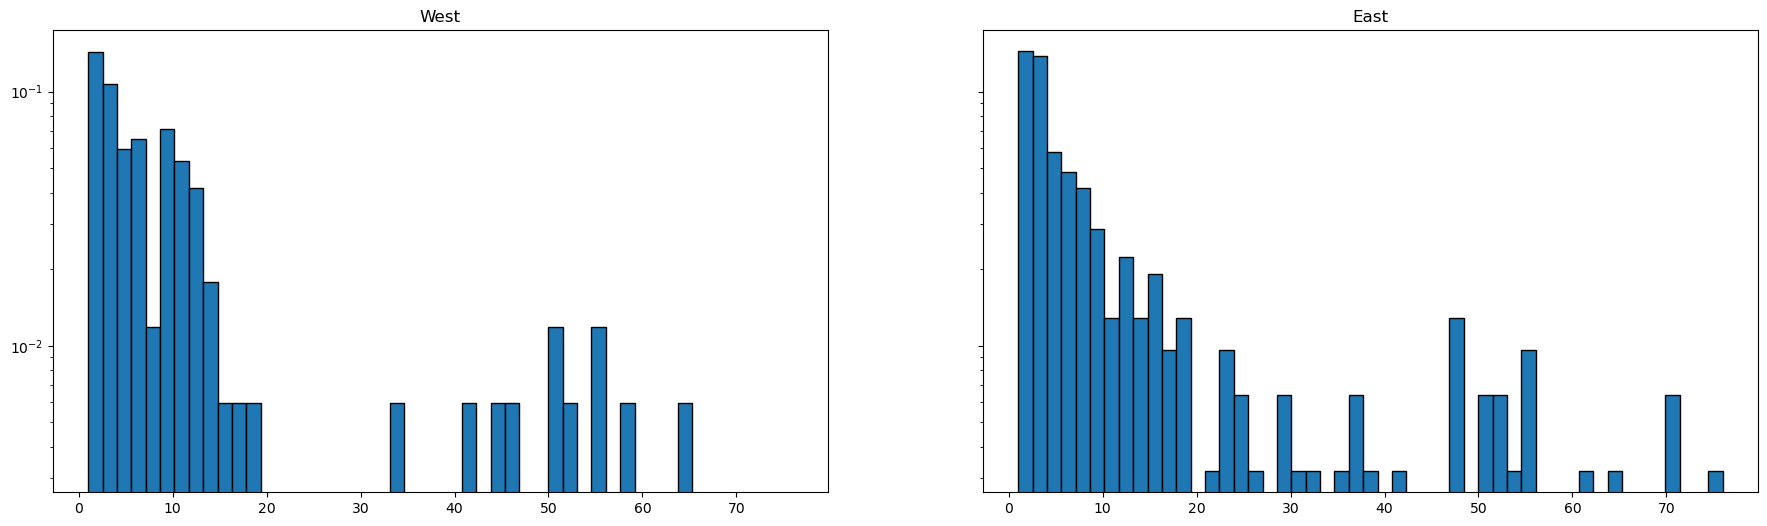

In [29]:
_ = metric_analysis(SIM=SIM_Test, metric='radius', node_based=False, visualize=True, log=True, bin_num=50)